In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
%matplotlib inline
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import MinMaxScaler

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from matplotlib.gridspec import GridSpec
from collections import defaultdict
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import LinearSVC
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut, LeaveOneOut, KFold
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, confusion_matrix
from sklearn.neighbors import KNeighborsRegressor

In [3]:
def _plot_cm(y_true, y_pred, ax, ax_labels, title):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm / cm.sum(axis=1, keepdims=True)
    im = ax.imshow(cm, cmap='cubehelix', vmin=0, vmax=1)
    plt.xticks(range(len(ax_labels)), ax_labels)
    plt.yticks(range(len(ax_labels)), ax_labels)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Real')
    ax.set_title(title)
    return im

def plot_cm(y_true, y_pred, y_shuffle_true, y_shuffle_pred):
    '''
    plot confusion matrix

    Args:
        y_true ([np.array]): array for true label
        y_pred ([np.array]): array for predicted label
        y_shuffle_true ([np.array]): array for shffuled label
        y_shuffle_pred ([np.array]): array for shuffled predicted label
    '''
    fig = plt.figure(figsize=(23, 10), facecolor='white')
    gs = GridSpec(ncols=3, nrows=1, wspace=0.1, figure = fig, width_ratios=[10,10,0.3])
    fig_ax = fig.add_subplot(gs[0,0])
    labels = np.unique(y_true)
    _plot_cm(y_true, y_pred, fig_ax, labels, f'Real Accuracy {accuracy_score(y_true, y_pred):0.2f}')

    fig_ax = fig.add_subplot(gs[0,1])
    im = _plot_cm(y_shuffle_true, y_shuffle_pred, fig_ax, labels, f'Shuffle Accuracy {accuracy_score(y_shuffle_true, y_shuffle_pred):0.2f}')
    fig_ax.set_ylabel('')
    fig_ax.set_yticklabels([])

    # plot colorbar
    cb = fig.add_subplot(gs[0,2])
    fig.colorbar(mappable=im, cax=cb, label='Fraction of labels', )
    fig.tight_layout()
    plt.show()
    c = PlotConfig()
    #fig.savefig(c.dana_save_path / "age_vs_behavioral_age"/ 'age_decoder_confusion_pre.pdf')

In [4]:
format_plots()
#format_pizza_plots()

In [5]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmf=custom_cmap

colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [6]:
## update data
def remove_crl_male(df):
    max=40
    df.drop('9c060c9b-9eee-4788-90be-803700bbacd8',level=3, axis=0, inplace=True)
    syll=df.columns.values[df.columns.values>max]
    #syll=0
    df.drop(syll,axis=1, inplace=True)
    return df[~df.index.get_level_values('session_name').str.contains('CRL')]

def remove_crl_female(df):
    max=40
    #df.drop('9c060c9b-9eee-4788-90be-803700bbacd8',level=3, axis=0, inplace=True)
    syll=df.columns.values[df.columns.values>max]
    #syll=0
    df.drop(syll,axis=1, inplace=True)
    return df[~df.index.get_level_values('session_name').str.contains('CRL')]

In [7]:
# arrange data
# pseudo data males
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_07/ontogeny_males_clean_pseudotime_v02.parquet')
m_psd = pd.read_parquet(path)
m_psd=m_psd.reset_index()
m_psd=m_psd[['uuid','pseudotime_rank','age']]

#make sure only animals in clean v2 are in the male dataframe:
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_07/ontogeny_males_clean_v2.parquet')
df_males = pd.read_parquet(path)
df_males = remove_crl_male(df_males)
m_psd = df_males.merge(m_psd, on='uuid', how='left')

#do some cleaning up
m_psd.rename(columns={'pseudotime_rank': 'psd'}, inplace=True)
m_psd.set_index(['psd','uuid','age'], append=True, inplace=True)
m_psd = m_psd.filter(regex=r'\d')

## convert male pseudotime to bins and remap the bins
m_psd['bins'] = pd.qcut(m_psd.index.get_level_values('psd'), len(m_psd.index.get_level_values('age').unique()),labels=False)

ages = m_psd.index.get_level_values('age').unique().to_numpy()
mapdr_males = dict(zip(list(range(len(ages))), ages))
y_temp = m_psd['bins'].to_numpy()
y_temp = [mapdr_males[item] for item in y_temp]

m_psd['remapped_bins'] = y_temp
m_psd.set_index(['bins','remapped_bins'], 
                append=True, inplace=True)

In [8]:
# arrange data
# pseudo data females
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_07/ontogeny_females_clean_pseudotime_v02.parquet')
f_psd = pd.read_parquet(path)
f_psd=f_psd.reset_index()
f_psd=f_psd[['uuid','pseudotime_rank','age']]

#make sure only animals in clean v2 are in the female dataframe:
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_07/ontogeny_females_clean_v2.parquet')
df_females = pd.read_parquet(path)
df_females = remove_crl_female(df_females)
f_psd = df_females.merge(f_psd, on='uuid', how='left')

#do some cleaning up
f_psd.rename(columns={'pseudotime_rank': 'psd'}, inplace=True)
f_psd.set_index(['psd','uuid','age'], append=True, inplace=True)
f_psd = f_psd.filter(regex=r'\d')

## convert male pseudotime to bins and remap the bins
f_psd['bins'] = pd.qcut(f_psd.index.get_level_values('psd'), len(f_psd.index.get_level_values('age').unique()),labels=False)

ages = f_psd.index.get_level_values('age').unique().to_numpy()
mapdr_females = dict(zip(list(range(len(ages))), ages))
y_temp = f_psd['bins'].to_numpy()
y_temp = [mapdr_females[item] for item in y_temp]

f_psd['remapped_bins'] = y_temp
f_psd.set_index(['bins','remapped_bins'], 
                append=True, inplace=True)

In [9]:
# pseudo regression
from sklearn.cross_decomposition import PLSRegression
from sklearn import neighbors
mdl= neighbors.KNeighborsRegressor(n_neighbors=8)
#mdl = PLSRegression(n_components=3)
x = m_psd.filter(regex=r'\d')
y = x.index.get_level_values('psd')
mdl.fit(x, y)
print(mdl.score(x, y))

#if you want to log transform
#x = np.log(x + 1e-6) # convert to linear
x = f_psd.filter(regex=r'\d')
psd=mdl.predict(x)

0.9881672363955992


In [10]:
# add female psd projected on males
f_psd['proj_psd'] = psd
f_psd['proj_bins'] = pd.qcut(f_psd.proj_psd, len(f_psd.index.get_level_values('age').unique()),labels=False)
y_temp = f_psd['proj_bins'].to_numpy()
y_temp = [mapdr_females[item] for item in y_temp]

f_psd['proj_remapped_bins'] = y_temp
f_psd.set_index(['proj_psd','proj_bins','proj_remapped_bins'], 
                append=True, inplace=True)

In [11]:
f_ages = f_psd.index.get_level_values('age').unique().to_numpy()
f_ages[f_ages==72]=78 
# look at syllable usage diff male and females according to actual age
m_data = m_psd.loc[m_psd.index.get_level_values('remapped_bins').isin(f_ages)]
m_data['sex'] = 'm'
m_data.rename(index={78: 72}, level='remapped_bins', inplace=True)
f_data = f_psd.copy()
f_data['sex'] = 'f'

In [12]:
m_data=m_data.reset_index()
m_data.set_index(['uuid','bins','remapped_bins','age','sex'], inplace=True)
m_data = m_data.filter(regex=r'\d')

f_data=f_data.reset_index()
f_data.set_index(['uuid','bins','remapped_bins','age','sex'], inplace=True)
f_data = f_data.filter(regex=r'\d')

In [13]:
data=pd.concat([m_data,f_data]).drop('level_0', axis=1)

In [14]:
# choose a model for decoder
# choose a model for decoder
clf = svm.SVC(kernel='linear') 
#clf = RandomForestClassifier(n_estimators = 200)
#clf = LinearRegression()
#clf = KNeighborsRegressor(n_neighbors=5)

# choose cross validation scheme
cv = LeaveOneOut()
#cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
#cv=5

#number of iterations for shuffle
it=1000

In [15]:
sh_ages=[]
age2=[]
acc=[]
sh_acc=[]
for age,_df in enumerate(data.groupby('remapped_bins')):
    #ages.extend(_df[1].index.get_level_values('remapped_bins').to_numpy())
    age2.append(_df[0])
    x = _df[1].to_numpy()
    x = np.log(x + 1e-6)
    y=_df[1].index.get_level_values('sex')
    y_pred = cross_val_predict(clf, x, y, cv=cv)
    acc.append(np.mean(cross_val_score(clf, x, y, cv=cv)))
    for i in tqdm(range(it)):
        sh_ages.append(_df[0])
        ysh_temp=np.random.permutation(y)
        sh_acc.append(np.mean(cross_val_score(clf, x, ysh_temp, cv=cv)))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:16<00:00, 13.13it/s]


In [16]:
_df

(72,
                                                                        0   \
 uuid                                 bins remapped_bins age sex             
 82934604-60a2-4ce8-b2a7-82bd40b79d9d 14   72            20  m    0.066554   
 8a23fe9c-a3b9-4a37-8c6c-346cd6ed688c 14   72            36  m    0.042750   
 2b1fc534-9f84-4f4a-be5d-18bd6b25f428 14   72            36  m    0.038835   
 abc016ff-5f28-48b1-aed8-974951ced0c4 14   72            52  m    0.025344   
 b2303e6e-ce21-45ff-b8ba-133942278db6 14   72            56  m    0.032244   
 f5d03365-70d8-4c66-8ee1-f8597341eb00 14   72            56  m    0.036243   
 290c33c5-c381-43ea-9436-88d1763aa466 14   72            72  m    0.041260   
 2f8712ca-a0d7-4df3-b912-47f3a48d3d46 14   72            72  m    0.035401   
 f4ab9587-241f-4973-afec-43686671055b 14   72            72  m    0.039256   
 cf24ee03-eed3-4e5b-96c5-9971c81988d9 14   72            78  m    0.048662   
 f950ee2d-ddaa-4206-8f86-f367d077a2e2 14   72            78

In [17]:
# create df for plotting
df_sh = pd.DataFrame()
df_sh['acc']=sh_acc
df_sh['ages'] = sh_ages

df = pd.DataFrame()
df['acc']=acc
df['ages'] = age2

(array([-20.,   0.,  20.,  40.,  60.,  80.]),
 [Text(-20.0, 0, '−20'),
  Text(0.0, 0, '0'),
  Text(20.0, 0, '20'),
  Text(40.0, 0, '40'),
  Text(60.0, 0, '60'),
  Text(80.0, 0, '80')])

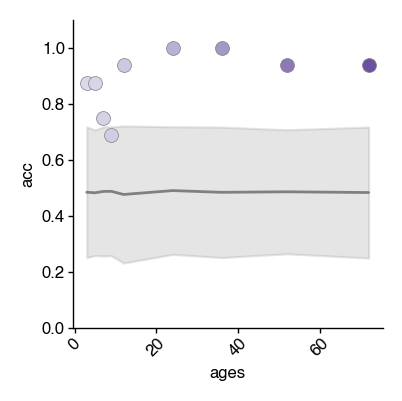

In [22]:
fig, ax = plt.subplots(figsize=(2, 2))
#sns.violinplot(data=df_sh, x="ages", y="acc", ax=ax, color='gray')
sns.lineplot(data=df_sh, x="ages", y="acc", ax=ax, color='gray', estimator='mean', errorbar=('sd', 2))
#sns.pointplot(data=df, x="ages", y="acc",
              #xticklabels=1,
              #dodge=0, 
#              join=False, 
#              ax=ax, 
#              scale=1,
#              hue='ages',
 #             palette='Blues',
              #edgecolor='gray',
              #linewidth=0.3
 #            )
#sns.lineplot(data=df, x="ages", y="acc", ax=ax, color='gray')
sns.lineplot (data=df, x='ages', y='acc', 
              markers=True, 
              marker='o',
              markersize=5,
              palette = cmm,
              hue='ages',
              linestyle='-',
              markeredgecolor='grey', 
              markeredgewidth=0.25,
             legend=False)
plt.ylim([0.0,1.1])
plt.legend([],[], frameon=False)
sns.despine()
plt.xticks(rotation=45)


In [23]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig4"/ 'fvm_sex_decoder.pdf', bbox_inches='tight')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, '3'),
  Text(1, 0, '5'),
  Text(2, 0, '7'),
  Text(3, 0, '9'),
  Text(4, 0, '12'),
  Text(5, 0, '24'),
  Text(6, 0, '36'),
  Text(7, 0, '52'),
  Text(8, 0, '72')])

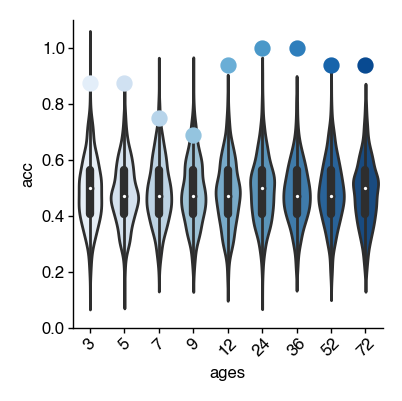

In [20]:
fig, ax = plt.subplots(figsize=(2, 2))
sns.violinplot(data=df_sh, x="ages", y="acc", ax=ax, 
               #color='gray', 
               palette = 'Blues', 
               fill = False,
                inner_kws=dict(box_width=15, whis_width=2, color=".8"),
               #hue='ages',
              )
#sns.lineplot(data=df_sh, x="ages", y="acc", ax=ax, color='gray', estimator='mean', errorbar=('sd', 2))
sns.pointplot(data=df, x="ages", y="acc",
              #xticklabels=1,
              dodge=0, 
              join=False, 
              ax=ax, 
              scale=1,
              hue='ages',
             palette='Blues',
              #edgecolor='gray',
              #linewidth=0.3
            )

plt.ylim([0,1.1])
plt.legend([],[], frameon=False)
sns.despine()
plt.xticks(rotation=45)